In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics

from xgboost import XGBClassifier


from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    
    precision=precision_score(Y_test,y_pred_test)
    recall=recall_score(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc,precision,recall
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

# def Logistic_model(X_train,Y_train,X_test,Y_test):
#     print('\033[1m' + 'Logistic Regression' + '\033[0m')
#     log=LogisticRegression()
#     log.fit(X_train,Y_train)
    
#     return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    precision=precision_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    recall=recall_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

In [4]:
### Read HTML 
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)
count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)


### Read JS 
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')
cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)
df_js.rename(columns={'Malicious':'Target'},inplace=True)
print("Shape of JS,DOM dataset:",df_js.shape)
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read HTTP
df_http=pd.read_csv('HTTP.csv')
df_http.rename(columns={'Malicious':'Target'},inplace=True)
df_http.fillna(value=0,inplace=True)
cookies=[columns for columns in df_http.columns if 'number' in columns]
df_http.drop(cookies,axis=1,inplace=True)
df_http=df_http[df_http['domain']!=0]
df_http.sort_values(by='Target',inplace=True,ascending=False)
df_http.drop_duplicates(['domain'], keep='first',inplace=True)
df_http=df_http.sample(frac=1,random_state=0)
df_http.set_index(['domain'],drop=True,inplace=True)
print("Shape of HTTP dataset:",df_http.shape)



### Read URL
df_url=pd.read_csv('URL.csv')
df_url.fillna(value=0,inplace=True)
cookies=[columns for columns in df_url.columns if 'number' in columns]
df_url.drop(cookies,axis=1,inplace=True)
df_url.drop(['url_host','url_ip'],axis=1,inplace=True)
df_url=df_url[df_url['domain']!=0]
df_url.sort_values(by='Target',inplace=True,ascending=False)
df_url.drop_duplicates(['domain'], keep='first',inplace=True)
df_url=df_url.sample(frac=1,random_state=0)
print("Shape of URL dataset:",df_url.shape)
df_url.set_index('domain',inplace=True,drop=True)

Shape of HTML dataset: (43491, 1461)
Shape of JS,DOM dataset: (43294, 401)
Shape of HTTP dataset: (45856, 672)
Shape of URL dataset: (46771, 4194)


In [5]:
df=pd.concat([df_js,df_html,df_http,df_url],axis=1,join='inner')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df['Target_z']=df[['Target','Target','Target','Target']].apply(max,axis=1)
df.drop(['Target','Target','Target','Target'],axis=1,inplace=True)
print("Shape of combined dataset:",df.shape)
df.rename(columns={'Target_z':'Target'},inplace=True)
df.Target.value_counts()

Shape of combined dataset: (39183, 6726)


0    34742
1     4441
Name: Target, dtype: int64

In [6]:
columns=['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

print("features being used")
display(columns)

features being used


['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

### <a id='1' style="text-decoration : none; color : #000000;"> 1. Initial Models</a>

In [8]:
df_sel=df[columns].copy(deep=True)

train=df_sel.iloc[:27428,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[27428:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')

ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9795829079772496
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24148   179    24327
True         381  2720     3101
__all__    24529  2899    27428

Accuracy of the model for test data is: 0.9723521905572097
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10301   114    10415
True         211  1129     1340
__all__    10512  1243    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.996536386174712
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24307    20    24327
True          75  3026     3101
__all__    24382  3046    27428

Accuracy of the model for test data is: 0.978477243726074
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10345    70    10415
True         183  1157     1340
__all__    10528  1227    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9726556803266735
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23997   330    24327
True         420  2681     3101
__all__    24417  3011    27428

Accuracy of the model for test data is: 0.9706507868991918
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10267   148    10415
True         197  1143     1340
__all__    10464  1291    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9807131398570803
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24180   147    24327
True         382  2719     3101
__all__    24562  2866    27428

Accuracy of the model for test data is: 0.976860910250957
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10334    81    10415
True         191  1149     1340
__all__    10525  1230    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9981405862622138
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24324     3    24327
True          48  3053     3101
__all__    24372  3056    27428

Accuracy of the model for test data is: 0.9767758400680562
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10332    83    10415
True         190  1150     1340
__all__    10522  1233    11755



XGB Classifier
Accuracy of the model for training data is: 0.9794735306985562
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24179   148    24327
True         415  2686     3101
__all__    24594  2834    27428

Accuracy of the model for test data is: 0.9758400680561463
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10336    79    10415
True         205  1135     1340
__all__    10541  1214    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9963176316173253
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24308    19    24327
True          82  3019     3101
__all__    24390  3038    27428

Accuracy of the model for test data is: 0.9762654189706508
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10324    91    10415
True         188  1152     1340
__all__    10512  1243    11755



Neural Network-1
The accuracy of the model on training data is: 0.9923071313985709


Predicted  False  True  __all__
Actual                         
False      24247    80    24327
True         131  2970     3101
__all__    24378  3050    27428

The accuracy of the model on test data is: 0.9732028923862186


Predicted  False  True  __all__
Actual                         
False      10275   140    10415
True         175  1165     1340
__all__    10450  1305    11755

### <a id='1.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [9]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [10]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.979583,2720.0,24148.0,179.0,381.0,0.007358,0.122864
RandomForestClassifier,0.996536,3026.0,24307.0,20.0,75.0,0.000822,0.024186
AdaBoostClassifier,0.972656,2681.0,23997.0,330.0,420.0,0.013565,0.135440
GradientBoostingClassifier,0.980713,2719.0,24180.0,147.0,382.0,0.006043,0.123186
ExtraTreeClassifier,0.998141,3053.0,24324.0,3.0,48.0,0.000123,0.015479
XGB,0.979474,2686.0,24179.0,148.0,415.0,0.006084,0.133828
BaggingClassifier,0.996318,3019.0,24308.0,19.0,82.0,0.000781,0.026443
Neural Network-1,0.992307,2970.0,24247.0,80.0,131.0,0.003289,0.042244


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.972352,1129.0,10301.0,114.0,211.0,0.010946,0.157463,0.915796,0.859437,0.908286,0.842537
RandomForestClassifier,0.978477,1157.0,10345.0,70.0,183.0,0.006721,0.136567,0.928356,0.890475,0.942950,0.863433
AdaBoostClassifier,0.970651,1143.0,10267.0,148.0,197.0,0.014210,0.147015,0.919387,0.852541,0.885360,0.852985
GradientBoostingClassifier,0.976861,1149.0,10334.0,81.0,191.0,0.007777,0.142537,0.924843,0.882219,0.934146,0.857463
ExtraTreeClassifier,0.976776,1150.0,10332.0,83.0,190.0,0.007969,0.141791,0.925120,0.881846,0.932685,0.858209
XGB,0.975840,1135.0,10336.0,79.0,205.0,0.007585,0.152985,0.919715,0.876630,0.934926,0.847015
BaggingClassifier,0.976265,1152.0,10324.0,91.0,188.0,0.008737,0.140299,0.925482,0.879458,0.926790,0.859701
Neural Network-1,0.973203,1165.0,10275.0,140.0,175.0,0.013442,0.130597,0.925482,0.865910,0.892720,0.869403


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [11]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [12]:
sm = SMOTE(random_state=12, ratio = {1:24327})
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)


ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9808032227566079
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23502    825    24327
True         109  24218    24327
__all__    23611  25043    48654

Accuracy of the model for test data is: 0.9456401531263292
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9903   512    10415
True         127  1213     1340
__all__    10030  1725    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9982529699510831
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24291     36    24327
True          49  24278    24327
__all__    24340  24314    48654

Accuracy of the model for test data is: 0.9760102084219481
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10306   109    10415
True         173  1167     1340
__all__    10479  1276    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9591811567394253
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23269   1058    24327
True         928  23399    24327
__all__    24197  24457    48654

Accuracy of the model for test data is: 0.952190557209698
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9953   462    10415
True         100  1240     1340
__all__    10053  1702    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9724585851111933
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23665    662    24327
True         678  23649    24327
__all__    24343  24311    48654

Accuracy of the model for test data is: 0.9630795406210123
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10111   304    10415
True         130  1210     1340
__all__    10241  1514    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9989517819706499
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24324      3    24327
True          48  24279    24327
__all__    24372  24282    48654

Accuracy of the model for test data is: 0.9750744364100383
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10300   115    10415
True         178  1162     1340
__all__    10478  1277    11755



XGB Classifier
Accuracy of the model for training data is: 0.9702593825790274
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23616    711    24327
True         736  23591    24327
__all__    24352  24302    48654

Accuracy of the model for test data is: 0.9627392598894088
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10096   319    10415
True         119  1221     1340
__all__    10215  1540    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9978830106466067
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24292     35    24327
True          68  24259    24327
__all__    24360  24294    48654

Accuracy of the model for test data is: 0.9724372607401106
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10268   147    10415
True         177  1163     1340
__all__    10445  1310    11755



Neural Network-1
The accuracy of the model on training data is: 0.9914292761056105


Predicted  False   True  __all__
Actual                          
False      24016    311    24327
True         106  24221    24327
__all__    24122  24532    48654

The accuracy of the model on test data is: 0.9599319438536793


Predicted  False  True  __all__
Actual                         
False      10103   312    10415
True         159  1181     1340
__all__    10262  1493    11755

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [13]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [14]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.980803,24218.0,23502.0,825.0,109.0,0.033913,0.004481
RandomForestClassifier,0.998253,24278.0,24291.0,36.0,49.0,0.001480,0.002014
AdaBoostClassifier,0.959181,23399.0,23269.0,1058.0,928.0,0.043491,0.038147
GradientBoostingClassifier,0.972459,23649.0,23665.0,662.0,678.0,0.027213,0.027870
ExtraTreeClassifier,0.998952,24279.0,24324.0,3.0,48.0,0.000123,0.001973
XGB,0.970259,23591.0,23616.0,711.0,736.0,0.029227,0.030254
BaggingClassifier,0.997883,24259.0,24292.0,35.0,68.0,0.001439,0.002795
Neural Network-1,0.991429,24221.0,24016.0,311.0,106.0,0.012784,0.004357


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.945640,1213.0,9903.0,512.0,127.0,0.049160,0.094776,0.928032,0.768853,0.703188,0.905224
RandomForestClassifier,0.976010,1167.0,10306.0,109.0,173.0,0.010466,0.129104,0.930215,0.879047,0.914577,0.870896
AdaBoostClassifier,0.952191,1240.0,9953.0,462.0,100.0,0.044359,0.074627,0.940507,0.795678,0.728555,0.925373
GradientBoostingClassifier,0.963080,1210.0,10111.0,304.0,130.0,0.029189,0.097015,0.936898,0.829007,0.799207,0.902985
ExtraTreeClassifier,0.975074,1162.0,10300.0,115.0,178.0,0.011042,0.132836,0.928061,0.874346,0.909945,0.867164
XGB,0.962739,1221.0,10096.0,319.0,119.0,0.030629,0.088806,0.940283,0.829400,0.792857,0.911194
BaggingClassifier,0.972437,1163.0,10268.0,147.0,177.0,0.014114,0.132090,0.926898,0.862276,0.887786,0.867910
Neural Network-1,0.959932,1181.0,10103.0,312.0,159.0,0.029957,0.118657,0.926898,0.812574,0.791025,0.881343


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [15]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;">3. UnderSampling </a>

In [16]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

Shape after undersampling (6202, 34)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.9477587874879071
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2942   159     3101
True         165  2936     3101
__all__     3107  3095     6202

Accuracy of the model for test data is: 0.9304125903870694
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9708   707    10415
True         111  1229     1340
__all__     9819  1936    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9945178974524347
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3092     9     3101
True          25  3076     3101
__all__     3117  3085     6202

Accuracy of the model for test data is: 0.95618885580604
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10009   406    10415
True         109  1231     1340
__all__    10118  1637    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9448564979039019
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2932   169     3101
True         173  2928     3101
__all__     3105  3097     6202

Accuracy of the model for test data is: 0.9440238196512123
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9844   571    10415
True          87  1253     1340
__all__     9931  1824    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9548532731376975
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2961   140     3101
True         140  2961     3101
__all__     3101  3101     6202

Accuracy of the model for test data is: 0.9519353466609953
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9934   481    10415
True          84  1256     1340
__all__    10018  1737    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9975814253466624
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3101     0     3101
True          15  3086     3101
__all__     3116  3086     6202

Accuracy of the model for test data is: 0.9578902594640578
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10034   381    10415
True         114  1226     1340
__all__    10148  1607    11755



XGB Classifier
Accuracy of the model for training data is: 0.9530796517252499
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2966   135     3101
True         156  2945     3101
__all__     3122  3080     6202

Accuracy of the model for test data is: 0.9524457677584007
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9941   474    10415
True          85  1255     1340
__all__    10026  1729    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9932279909706546
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3088    13     3101
True          29  3072     3101
__all__     3117  3085     6202

Accuracy of the model for test data is: 0.9524457677584007
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9973   442    10415
True         117  1223     1340
__all__    10090  1665    11755



Neural Network-1
The accuracy of the model on training data is: 0.9850048371493066


Predicted  False  True  __all__
Actual                         
False       3092     9     3101
True          84  3017     3101
__all__     3176  3026     6202

The accuracy of the model on test data is: 0.9562739259889409


Predicted  False  True  __all__
Actual                         
False      10034   381    10415
True         133  1207     1340
__all__    10167  1588    11755

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [17]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [18]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.947759,2936.0,2942.0,159.0,165.0,0.051274,0.053209
RandomForestClassifier,0.994518,3076.0,3092.0,9.0,25.0,0.002902,0.008062
AdaBoostClassifier,0.944856,2928.0,2932.0,169.0,173.0,0.054499,0.055788
GradientBoostingClassifier,0.954853,2961.0,2961.0,140.0,140.0,0.045147,0.045147
ExtraTreeClassifier,0.997581,3086.0,3101.0,0.0,15.0,0.000000,0.004837
XGB,0.953080,2945.0,2966.0,135.0,156.0,0.043534,0.050306
BaggingClassifier,0.993228,3072.0,3088.0,13.0,29.0,0.004192,0.009352
Neural Network-1,0.985005,3017.0,3092.0,9.0,84.0,0.002902,0.027088


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.930413,1229.0,9708.0,707.0,111.0,0.067883,0.082836,0.924641,0.727691,0.634814,0.917164
RandomForestClassifier,0.956189,1231.0,10009.0,406.0,109.0,0.038982,0.081343,0.939837,0.807481,0.751985,0.918657
AdaBoostClassifier,0.944024,1253.0,9844.0,571.0,87.0,0.054825,0.064925,0.940125,0.772643,0.686952,0.935075
GradientBoostingClassifier,0.951935,1256.0,9934.0,481.0,84.0,0.046183,0.062687,0.945565,0.798055,0.723086,0.937313
ExtraTreeClassifier,0.957890,1226.0,10034.0,381.0,114.0,0.036582,0.085075,0.939172,0.812547,0.762912,0.914925
XGB,0.952446,1255.0,9941.0,474.0,85.0,0.045511,0.063433,0.945528,0.799513,0.725853,0.936567
BaggingClassifier,0.952446,1223.0,9973.0,442.0,117.0,0.042439,0.087313,0.935124,0.793181,0.734535,0.912687
Neural Network-1,0.956274,1207.0,10034.0,381.0,133.0,0.036582,0.099254,0.935124,0.803446,0.760076,0.900746


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [19]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [20]:
df.reset_index(inplace=True)
columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2278 features
EntitySet scattered to workers in 4.238 seconds
Elapsed: 00:13 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [21]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)
fs=fs.reindex(df.index.values)
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [22]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y)

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()

In [23]:
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [24]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.3)
print('Features we will be using:\n')
display(feature_name)

The train/test split ratio is 70:30
Features we will be using:



['url_length / total_count',
 'url_extensions / total_count',
 'url_char_w + url_char_z',
 'url_char_. / total_count',
 'url_char_. + url_char_w',
 'http_header_server_apache / total_count',
 'http_header_server_apache + url_char_w',
 'a_href_relative / total_href',
 'url_extensions / url_char_z',
 'url_extensions',
 'url_char_z / total_count',
 'url_char_y * url_extensions',
 'url_char_w / total_count',
 'url_char_w + url_extensions',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p / total_count',
 'url_char_p + url_extensions',
 'url_char_l / total_count',
 'url_char_i / total_count',
 'url_char_f / total_count',
 'url_char_f + url_extensions',
 'url_char_f + url_char_w',
 'url_char_. + url_extensions',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_via_1.1 + url_extensions',
 'http_header_vary_user-agent + url_extensions',
 'http_header_vary_user-agent + url_char_.',
 'http_head

In [25]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:27428]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[27428:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9792547761411696
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24163   164    24327
True         405  2696     3101
__all__    24568  2860    27428

Accuracy of the model for test data is: 0.9715865589111017
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10312   103    10415
True         231  1109     1340
__all__    10543  1212    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9951873997374945
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24299    28    24327
True         104  2997     3101
__all__    24403  3025    27428

Accuracy of the model for test data is: 0.9762654189706508
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10338    77    10415
True         202  1138     1340
__all__    10540  1215    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9753171941082106
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24099   228    24327
True         449  2652     3101
__all__    24548  2880    27428

Accuracy of the model for test data is: 0.9711612079965972
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10293   122    10415
True         217  1123     1340
__all__    10510  1245    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9808589762286715
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24195   132    24327
True         393  2708     3101
__all__    24588  2840    27428

Accuracy of the model for test data is: 0.9759251382390473
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10349    66    10415
True         217  1123     1340
__all__    10566  1189    11755

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method



ExtraTree Classifier
Accuracy of the model for training data is: 0.9973020271255651
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24319     8    24327
True          66  3035     3101
__all__    24385  3043    27428

Accuracy of the model for test data is: 0.9755848575074436
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10329    86    10415
True         201  1139     1340
__all__    10530  1225    11755



XGB Classifier
Accuracy of the model for training data is: 0.9799474989062272
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24201   126    24327
True         424  2677     3101
__all__    24625  2803    27428

Accuracy of the model for test data is: 0.9749042960442365
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10341    74    10415
True         221  1119     1340
__all__    10562  1193    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9952603179232901
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24293    34    24327
True          96  3005     3101
__all__    24389  3039    27428

Accuracy of the model for test data is: 0.9762654189706508
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10321    94    10415
True         185  1155     1340
__all__    10506  1249    11755



Neural Network-1
The accuracy of the model on training data is: 0.9889528948519761


Predicted  False  True  __all__
Actual                         
False      24289    38    24327
True         265  2836     3101
__all__    24554  2874    27428

The accuracy of the model on test data is: 0.9741386643981285


Predicted  False  True  __all__
Actual                         
False      10311   104    10415
True         200  1140     1340
__all__    10511  1244    11755

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [26]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [27]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.979255,2696.0,24163.0,164.0,405.0,0.006741,0.130603
RandomForestClassifier,0.995187,2997.0,24299.0,28.0,104.0,0.001151,0.033538
AdaBoostClassifier,0.975317,2652.0,24099.0,228.0,449.0,0.009372,0.144792
GradientBoostingClassifier,0.980859,2708.0,24195.0,132.0,393.0,0.005426,0.126733
ExtraTreeClassifier,0.997302,3035.0,24319.0,8.0,66.0,0.000329,0.021283
XGB,0.979947,2677.0,24201.0,126.0,424.0,0.005179,0.136730
BaggingClassifier,0.995260,3005.0,24293.0,34.0,96.0,0.001398,0.030958
Neural Network-1,0.988953,2836.0,24289.0,38.0,265.0,0.001562,0.085456


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.971587,1109.0,10312.0,103.0,231.0,0.009890,0.172388,0.908861,0.854583,0.915017,0.827612
RandomForestClassifier,0.976265,1138.0,10338.0,77.0,202.0,0.007393,0.150746,0.920930,0.878848,0.936626,0.849254
AdaBoostClassifier,0.971161,1123.0,10293.0,122.0,217.0,0.011714,0.161940,0.913173,0.853410,0.902008,0.838060
GradientBoostingClassifier,0.975925,1123.0,10349.0,66.0,217.0,0.006337,0.161940,0.915861,0.876626,0.944491,0.838060
ExtraTreeClassifier,0.975585,1139.0,10329.0,86.0,201.0,0.008257,0.150000,0.920871,0.875546,0.929796,0.850000
XGB,0.974904,1119.0,10341.0,74.0,221.0,0.007105,0.164925,0.913985,0.871371,0.937972,0.835075
BaggingClassifier,0.976265,1155.0,10321.0,94.0,185.0,0.009025,0.138060,0.926457,0.879605,0.924740,0.861940
Neural Network-1,0.974139,1140.0,10311.0,104.0,200.0,0.009986,0.149254,0.926457,0.868605,0.916399,0.850746


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [28]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 83.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 83.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 83.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 83.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 83.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

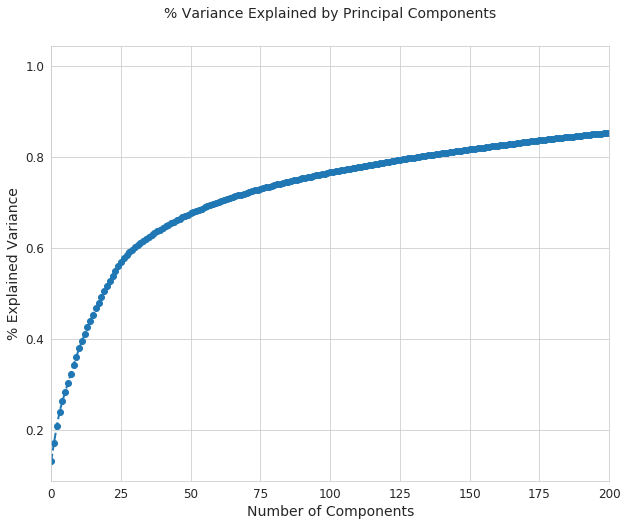

In [29]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [30]:
pca=PCA(n_components=125,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 125 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 125 components is: 0.7919073266420968


In [31]:
X_train=X_pca_21[:27428]
Y_train=fs.iloc[:27428]['Target'].values
X_test=X_pca_21[27428:]
Y_test=fs.iloc[27428:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [32]:
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,125).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9807860580428759
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24189   138    24327
True         389  2712     3101
__all__    24578  2850    27428

Accuracy of the model for test data is: 0.9723521905572097
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10327    88    10415
True         237  1103     1340
__all__    10564  1191    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9956978270380633
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24309    18    24327
True         100  3001     3101
__all__    24409  3019    27428

Accuracy of the model for test data is: 0.9730327520204168
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10342    73    10415
True         244  1096     1340
__all__    10586  1169    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9736400758349132
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24064   263    24327
True         460  2641     3101
__all__    24524  2904    27428

Accuracy of the model for test data is: 0.9686941726924713
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10279   136    10415
True         232  1108     1340
__all__    10511  1244    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.979509989791454
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24169   158    24327
True         404  2697     3101
__all__    24573  2855    27428

Accuracy of the model for test data is: 0.9726924712888133
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10318    97    10415
True         224  1116     1340
__all__    10542  1213    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9981405862622138
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24324     3    24327
True          48  3053     3101
__all__    24372  3056    27428

Accuracy of the model for test data is: 0.9696299447043811
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10349    66    10415
True         291  1049     1340
__all__    10640  1115    11755



XGB Classifier
Accuracy of the model for training data is: 0.9800933352778183
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24189   138    24327
True         408  2693     3101
__all__    24597  2831    27428

Accuracy of the model for test data is: 0.9745640153126329
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10329    86    10415
True         213  1127     1340
__all__    10542  1213    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9959894997812454
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24306    21    24327
True          89  3012     3101
__all__    24395  3033    27428

Accuracy of the model for test data is: 0.9730327520204168
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10329    86    10415
True         231  1109     1340
__all__    10560  1195    11755



Neural Network-1
The accuracy of the model on training data is: 0.9964999270818142


Predicted  False  True  __all__
Actual                         
False      24301    26    24327
True          70  3031     3101
__all__    24371  3057    27428

The accuracy of the model on test data is: 0.9745640153126329


Predicted  False  True  __all__
Actual                         
False      10297   118    10415
True         181  1159     1340
__all__    10478  1277    11755

In [33]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [34]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.980786,2712.0,24189.0,138.0,389.0,0.005673,0.125443
RandomForestClassifier,0.995698,3001.0,24309.0,18.0,100.0,0.000740,0.032248
AdaBoostClassifier,0.973640,2641.0,24064.0,263.0,460.0,0.010811,0.148339
GradientBoostingClassifier,0.979510,2697.0,24169.0,158.0,404.0,0.006495,0.130281
ExtraTreeClassifier,0.998141,3053.0,24324.0,3.0,48.0,0.000123,0.015479
XGB,0.980093,2693.0,24189.0,138.0,408.0,0.005673,0.131570
BaggingClassifier,0.995989,3012.0,24306.0,21.0,89.0,0.000863,0.028700
Neural Network-1,0.996500,3031.0,24301.0,26.0,70.0,0.001069,0.022573


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.972352,1103.0,10327.0,88.0,237.0,0.008449,0.176866,0.907342,0.858028,0.926113,0.823134
RandomForestClassifier,0.973033,1096.0,10342.0,73.0,244.0,0.007009,0.182090,0.905451,0.861146,0.937553,0.817910
AdaBoostClassifier,0.968694,1108.0,10279.0,136.0,232.0,0.013058,0.173134,0.906904,0.840759,0.890675,0.826866
GradientBoostingClassifier,0.972692,1116.0,10318.0,97.0,224.0,0.009313,0.167164,0.911761,0.860331,0.920033,0.832836
ExtraTreeClassifier,0.969630,1049.0,10349.0,66.0,291.0,0.006337,0.217164,0.888249,0.842199,0.940807,0.782836
XGB,0.974564,1127.0,10329.0,86.0,213.0,0.008257,0.158955,0.916394,0.870010,0.929101,0.841045
BaggingClassifier,0.973033,1109.0,10329.0,86.0,231.0,0.008257,0.172388,0.909677,0.861664,0.928033,0.827612
Neural Network-1,0.974564,1159.0,10297.0,118.0,181.0,0.011330,0.135075,0.909677,0.871765,0.907596,0.864925


In [35]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')